# Cálculo das taxas de retorno

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy import stats 

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Configurations
import warnings
warnings.filterwarnings("ignore")

# Configuração dos gráficos
from matplotlib import rc

# Estilo dos gráficos
# Referência: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # Formato das imagens

# Configurações de fontes
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":9})
rc('mathtext', **{"default":"regular"})

%matplotlib inline

In [51]:
# Define the date range
start_date = date.today() - timedelta(days=1825)
end_date = date.today()

# List of stocks and corresponding company names
stocks = ['POMO4.SA', 'WEGE3.SA', 'PETR4.SA', 'BTLG11.SA', 'MGLU3.SA', 'B3SA3.SA']
company_names = ["Marcopolo", "Weg", "Petrobras", "BTG logística","Magalu", "Bovespa"]
coluns = company_names.copy()

# Initialize a dictionary to store different types of price data
price_data_dict = {key: [] for key in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']}

def merge_dataframes(data_list):
    """Merge a list of DataFrames on the 'Date' column."""
    if not data_list:
        return None
    
    merged_df = data_list[0]
    if isinstance(merged_df.columns, pd.MultiIndex):
        merged_df.columns = merged_df.columns.get_level_values(0)

    for df in data_list[1:]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        merged_df = pd.merge(merged_df, df, on='Date', how='outer')
    
    return merged_df

def download_and_prepare_stock_data(stock_symbol, company_name):
    """Download stock data and prepare it for processing."""
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date).reset_index()
    
    for price_type in price_data_dict:
        if price_type in stock_data.columns:
            price_df = stock_data[['Date', price_type]].rename(columns={price_type: company_name})
            price_data_dict[price_type].append(price_df)

# Download and prepare data for each stock
for stock_symbol, company_name in zip(stocks, company_names):
    download_and_prepare_stock_data(stock_symbol, company_name)

# Combine all price type dataframes
df_adj_close = merge_dataframes(price_data_dict['Adj Close'])
df_close = merge_dataframes(price_data_dict['Close'])
df_high = merge_dataframes(price_data_dict['High'])
df_low = merge_dataframes(price_data_dict['Low'])
df_open = merge_dataframes(price_data_dict['Open'])
df_volume = merge_dataframes(price_data_dict['Volume'])
df_adj_close = df_adj_close.set_index('Date')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Taxas de retornos

### Retorno Simples do período

In [52]:
# Função para calcular e imprimir o retorno simples
def calculate_simple_return(df):
    """
    Calculate and print the simple return for a specific column in a DataFrame.
    
    Parameters:
    - column (str): The column name for which the simple return is calculated.
    - df (pd.DataFrame): The DataFrame containing the stock prices.
    """

    initial_price = df[column].iloc[0]
    final_price = df[column].iloc[-1]
    simple_return = round((final_price - initial_price) / initial_price,4)
    return simple_return

for column in df_adj_close.columns:
    simple_return = calculate_simple_return(df_adj_close)
    print(f'Empresa: {column}, Retorno Simples: {simple_return*100}')

Empresa: Marcopolo, Retorno Simples: 227.16
Empresa: Weg, Retorno Simples: 299.27000000000004
Empresa: Petrobras, Retorno Simples: 272.58
Empresa: BTG logística, Retorno Simples: 20.95
Empresa: Magalu, Retorno Simples: -90.91
Empresa: Bovespa, Retorno Simples: -23.09


## Retorno Diário

In [53]:
def calculate_daily_returns(df, company_names):
    """
    Calculate daily returns for each company in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing adjusted close prices with companies as columns.
    - company_names (list): List of company names (corresponding to DataFrame columns).

    Returns:
    - pd.DataFrame: DataFrame with daily returns added as new columns.
    """
    for column in company_names:
        df[column + ' Daily Return'] = df[column].pct_change()
    return df

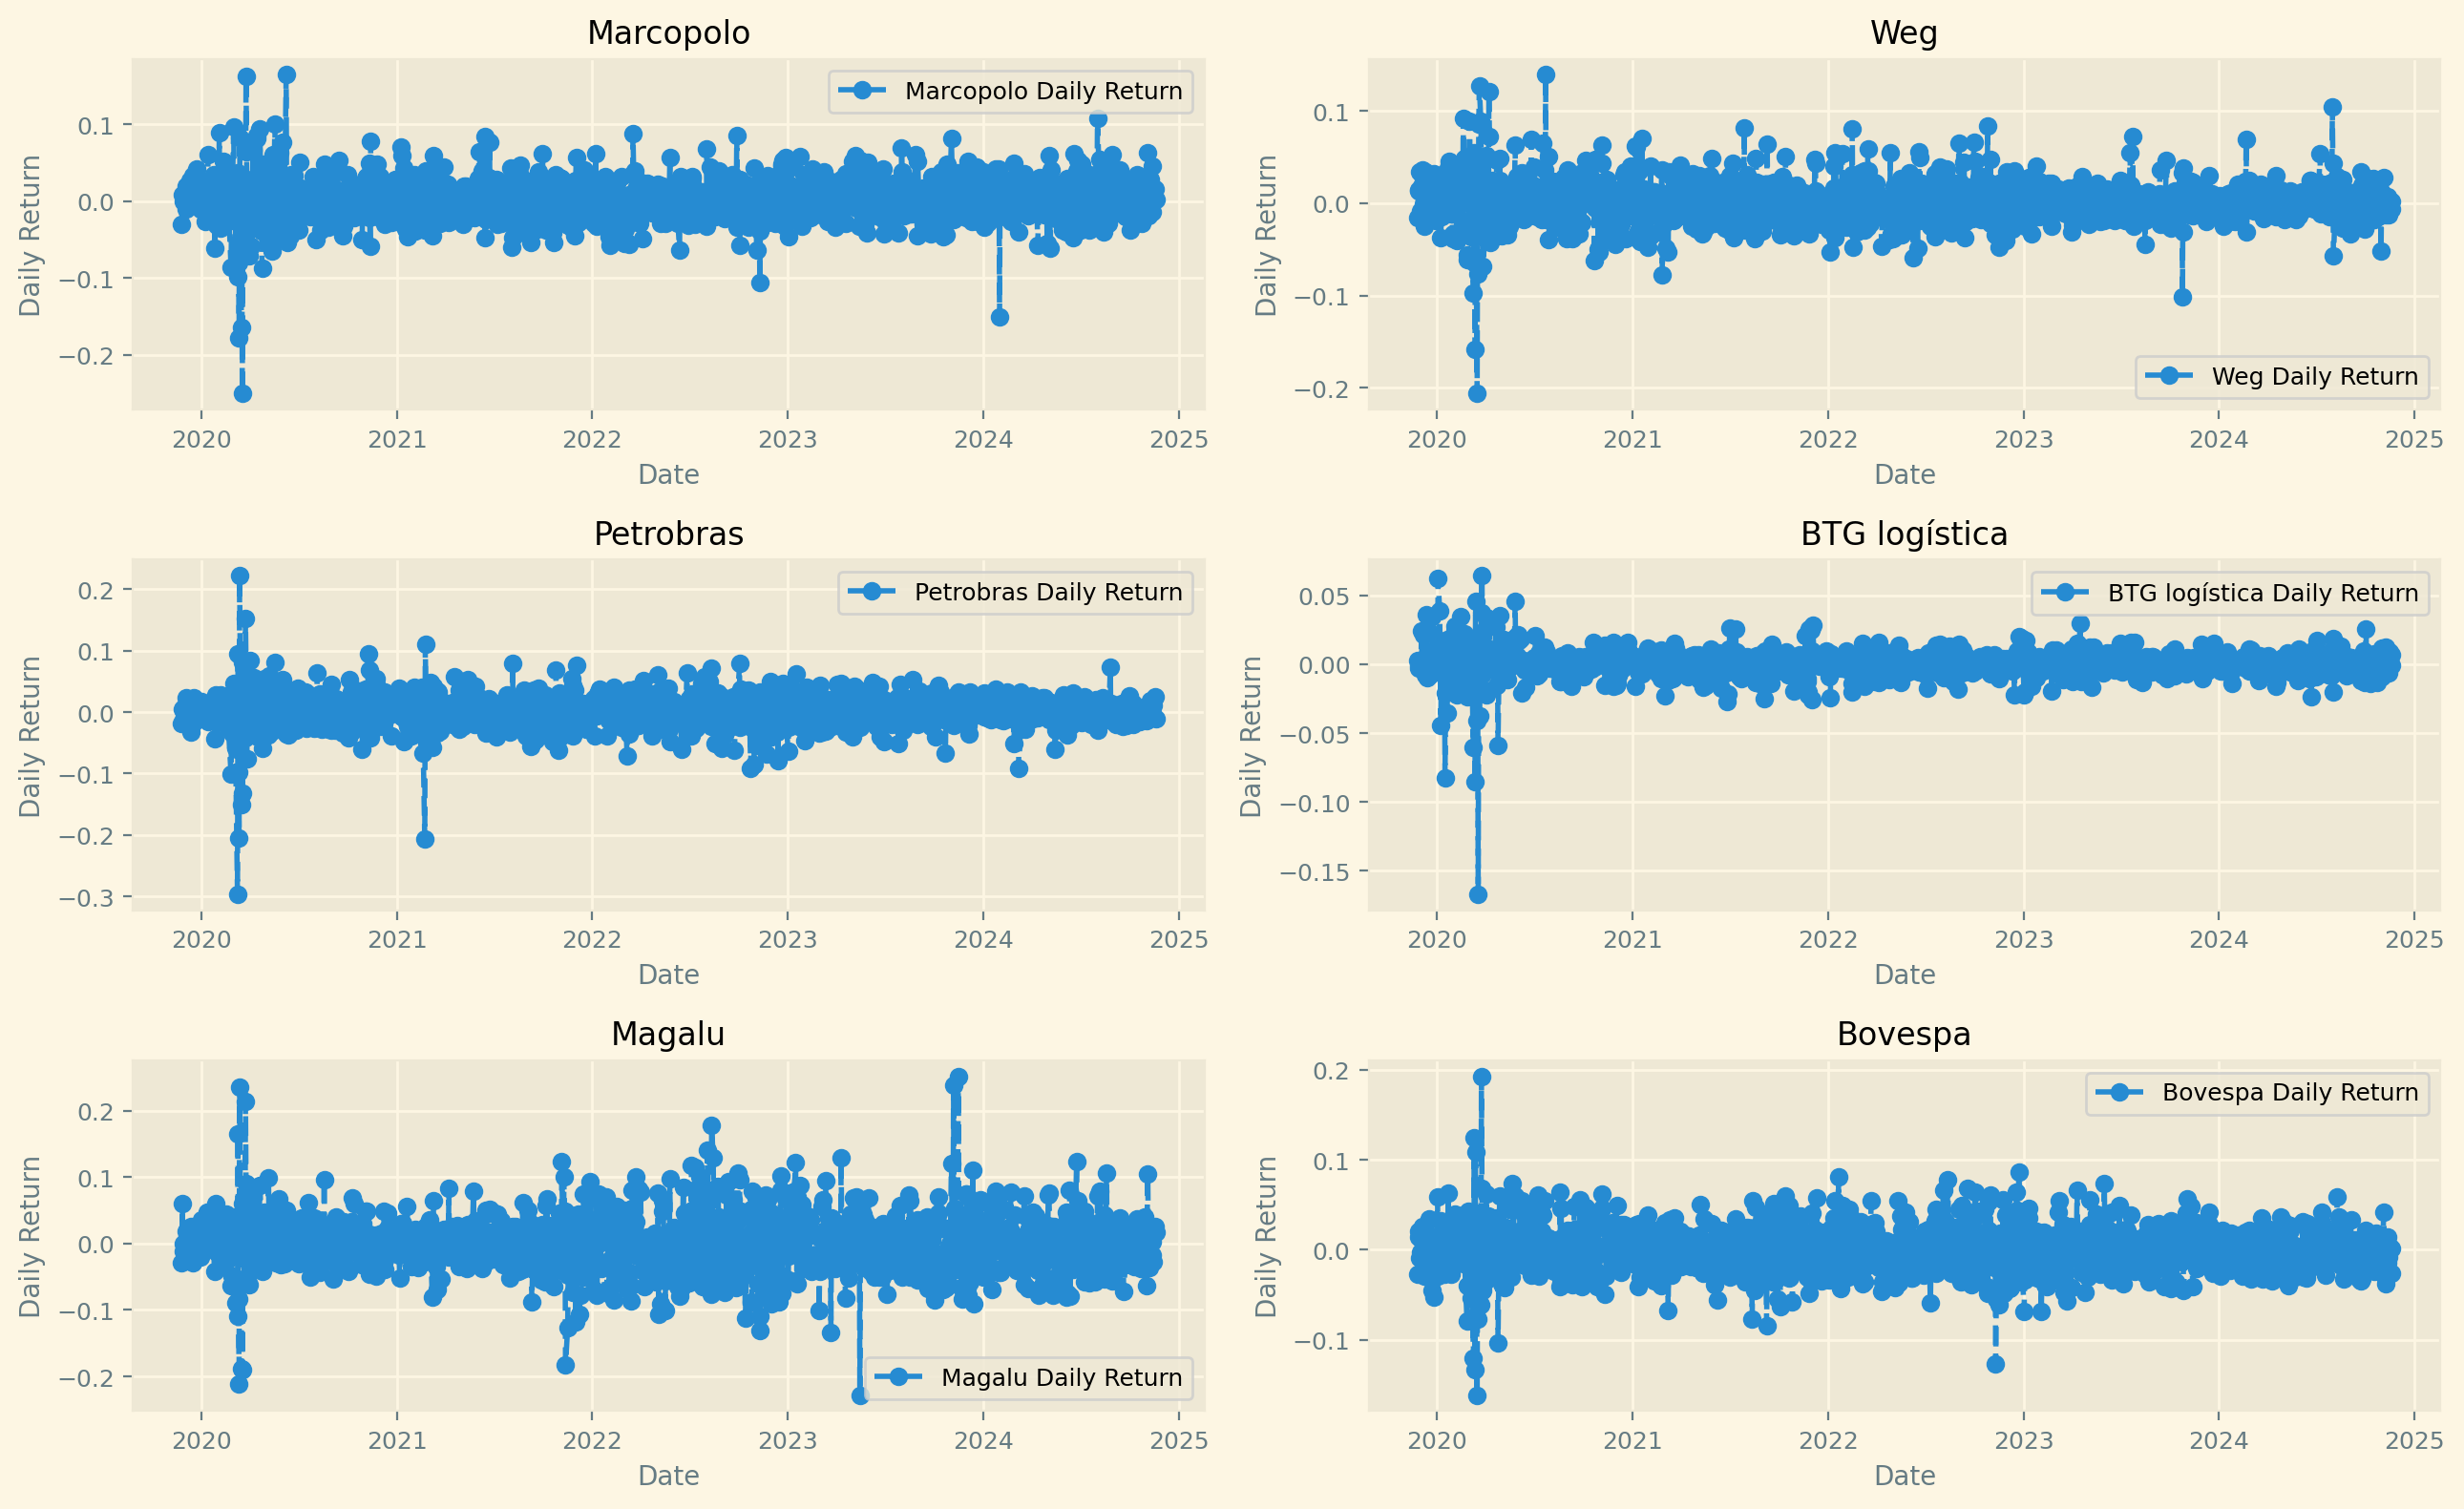

In [54]:
def plot_returns(df, return_type, company_names, figsize=(13, 8)):
    """
    Plot returns (daily or yearly) for each company.

    Parameters:
    - df (pd.DataFrame): DataFrame containing adjusted close prices and calculated returns.
    - return_type (str): Type of return to plot ('Daily Return' or 'Yearly Return').
    - company_names (list): List of company names (corresponding to DataFrame columns).
    - figsize (tuple): Size of the figure (width, height).
    """
    # Validate inputs
    if return_type not in ['Daily Return', 'Yearly Return']:
        raise ValueError("Invalid return_type. Use 'Daily Return' or 'Yearly Return'.")
    missing_columns = [col for col in company_names if f"{col} {return_type}" not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing return columns in DataFrame: {', '.join(missing_columns)}")
    
    num_companies = len(company_names)
    num_rows = (num_companies + 1) // 2  # Calculate rows needed for subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, company in enumerate(company_names):
        if i >= len(axes):  # Skip if more companies than subplots
            break

        ax = axes[i]
        column_name = f"{company} {return_type}"

        if return_type == 'Daily Return':
            ax.plot(df.index, df[column_name], linestyle='--', marker='o', label=f'{company} {return_type}')
        elif return_type == 'Yearly Return':
            ax.bar(df.index, df[column_name], label=f'{company} {return_type}')

        # Customize the subplot
        ax.set_title(company, fontsize=12)
        ax.set_ylabel(return_type, fontsize=10)
        ax.set_xlabel('Date' if return_type == 'Daily Return' else 'Year', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlap and improve spacing
    fig.tight_layout()

    # Show the plot
    plt.show()

# Example Usage
df = df_adj_close.copy()
company_names = list(df.columns)

# Add 'Carteira' (Portfolio) column and calculate its returns
df_daily_return = calculate_daily_returns(df_adj_close, company_names)

# Plot daily returns
plot_returns(df_daily_return, 'Daily Return', company_names)


In [56]:
# Calculate and print annualized return for each column containing "Daily Return"
for col in df_adj_close.columns:
    if 'Daily Return' in col:
        # Remove 'Daily Return' from the column name
        company_name = col.replace(' Daily Return', '')
        yearly_return = df_adj_close[col].mean() * 250  # Annualize daily return
        print(f'{company_name}, Retorno Anual: {yearly_return:.2%}')


Marcopolo, Retorno Anual: 34.31%
Weg, Retorno Anual: 35.12%
Petrobras, Retorno Anual: 36.71%
BTG logística, Retorno Anual: 5.32%
Magalu, Retorno Anual: -24.38%
Bovespa, Retorno Anual: 3.23%


### Taxa de Retorno Logarítmica

- Melhor para analisar ações da mesma empresa em períodos diferentes. 

In [57]:
def calculate_log_return(df):
    """
    Calculate and print the log return for a specific column in a DataFrame.
    
    Parameters:
    - column (str): The column name for which the log return is calculated.
    - df (pd.DataFrame): The DataFrame containing the stock prices.
    """

    initial_price = df[column].iloc[0]
    final_price = df[column].iloc[-1]
    log_return = round(np.log(final_price / initial_price), 4)
    return log_return

for column in df.columns:
    log_return = calculate_log_return(df_adj_close)
    print(f'{column}, Retorno Log: {log_return*100}')

Marcopolo, Retorno Log: 118.53
Weg, Retorno Log: 138.45000000000002
Petrobras, Retorno Log: 131.53
BTG logística, Retorno Log: 19.02
Magalu, Retorno Log: -239.82000000000002
Bovespa, Retorno Log: -26.25


In [58]:
for column in df.columns:
    if np.issubdtype(df[column].dtype, np.number):  # Ensure the column is numeric
        yearly_log = np.log(df[column] / df[column].shift(1)).mean() * 250
        print(f'{column}, Retorno Log Anual: {round(yearly_log*100, 2)}')

Marcopolo, Retorno Log Anual: 23.88
Weg, Retorno Log Anual: 27.89
Petrobras, Retorno Log Anual: 26.5
BTG logística, Retorno Log Anual: 3.83
Magalu, Retorno Log Anual: -48.31
Bovespa, Retorno Log Anual: -5.29
